In [1]:
# import public modules
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import datatable as dt

# import privatve modules
from vehicles.load_parameters import get_miscellaneous_constants
from vehicles.multirotor import multirotor
from controllers.geometric_SE3_tracking import geometric_SE3_tracking
from faultdetectors.PMI_observer import PMI_observer
from trajectories.hover_traj import HoverTraj



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def generate_save_traj_data(data_pair=10000, data_path=r'data', data_type=r'train'):

    # get miscellnaeous information
    const       =   get_miscellaneous_constants()

    # load the class instances
    quad        =   multirotor(model="parrotmambo",initial_state={'x': np.zeros((3,)), 'v': np.zeros((3,)), 'q': np.array([1.0, 0.0, 0.0, 0.0]), 'w': np.zeros((3,))})
    ctrl        =   geometric_SE3_tracking()
    obsv        =   PMI_observer()
    traj_hover  =   HoverTraj()

    # simulation time parameters
    t0          =   0.0
    tf          =   1.000
    tstep       =   0.01
    tsim        =   np.linspace(t0, tf, int((tf-t0)/tstep+1))

    # initialize the training set
    fault_type  =   quad.rotor_pos.shape[0]+1       # [-] each rotor fault + nominal case
    traj_data   =   np.empty((data_pair*fault_type,quad.vectorize(quad.initial_state).shape[0]+3+obsv.xhat0.shape[0]+quad.rotor_pos.shape[0],tsim.shape[0]), 
                            dtype=np.float64)       # [-] trajectory data (#datapairs, #states, #timehist)
    traj_label  =   np.empty((data_pair*fault_type, 2), dtype=np.float64)   # [-] label data (fault, instance)

    # create the nominal/faulty trajectories
    # note:
    # fault level: 15% of the loss in the rotation speed of each rotor
    # fault instance: randomly selected from 20% - 80% window of the simulation time
    # initial condition: randomly selected position in the box with 1m length, idle velocity/attitude/rate
    for traj_idx in tqdm(range(0,data_pair*fault_type)):

        fault_instance  =   np.int64(np.round((0.6*(np.random.rand(1)-0.5)+0.5)*(tf-t0)/tstep))

        x_temp          =   np.zeros((quad.vectorize(quad.initial_state).shape[0],tsim.shape[0]), dtype=np.float64)
        x_temp[:,0]     =   quad.vectorize(quad.initial_state)
        x_temp[0:3,0]   +=   1.0*(np.random.rand(3,)-0.5)
        x_eul_temp      =   np.zeros((3,tsim.shape[0]), dtype=np.float64)
        x_eul_temp[0:3,0]   =   obsv.quaternion_to_euler(x_temp[6:10,0])
        xhat_temp       =   np.zeros((obsv.xhat0.shape[0],tsim.shape[0]), dtype=np.float64)
        xhat_temp[:,0]  =   obsv.xhat0
        u_temp          =   np.zeros((quad.rotor_pos.shape[0],tsim.shape[0]), dtype=np.float64)

        if np.mod(traj_idx,fault_type) == 0:
            # simulation: nominal
            for sim_idx in range(0,len(tsim)-1):
                u_temp[:,sim_idx]           =   ctrl.update(tsim[sim_idx],quad.decompose(x_temp[:,sim_idx]),traj_hover.update(tsim[sim_idx]))
                (_,xhat_temp[:,sim_idx+1])  =   obsv.step(0, xhat_temp[:,sim_idx], quad.decompose(x_temp[:,sim_idx]), u_temp[:,sim_idx], tstep)
                (_,state_temp)              =   quad.step(0, quad.decompose(x_temp[:,sim_idx]), u_temp[:,sim_idx], tstep)
                x_temp[:,sim_idx+1]         =   quad.vectorize(state_temp)
                x_eul_temp[:,sim_idx+1]     =   obsv.quaternion_to_euler(state_temp['q'])

        else:
            # simulation: faulty cases
            for sim_idx in range(0,len(tsim)-1):
                u_temp[:,sim_idx]           =   ctrl.update(tsim[sim_idx],quad.decompose(x_temp[:,sim_idx]),traj_hover.update(tsim[sim_idx]))
                (_,xhat_temp[:,sim_idx+1])  =   obsv.step(0, xhat_temp[:,sim_idx], quad.decompose(x_temp[:,sim_idx]), u_temp[:,sim_idx], tstep)

                if sim_idx >= fault_instance:
                    u_temp[np.mod(traj_idx,fault_type)-1,sim_idx]   =   0.85*u_temp[np.mod(traj_idx,fault_type)-1,sim_idx]

                (_,state_temp)              =   quad.step(0, quad.decompose(x_temp[:,sim_idx]), u_temp[:,sim_idx], tstep)
                x_temp[:,sim_idx+1]         =   quad.vectorize(state_temp)
                x_eul_temp[:,sim_idx+1]     =   obsv.quaternion_to_euler(state_temp['q'])

        traj_data[traj_idx,:,:]     =   np.concatenate((x_temp, x_eul_temp, xhat_temp, u_temp),axis = 0)
        traj_label[traj_idx,0]      =   np.mod(traj_idx,fault_type)
        traj_label[traj_idx,1]      =   fault_instance

    traj_data_save      =   traj_data.reshape((data_pair*fault_type,-1))
    traj_label_save     =   traj_label.reshape((data_pair*fault_type,-1))

    traj_data_save_df   =   pd.DataFrame(traj_data_save)
    traj_label_save_df  =   pd.DataFrame(traj_label_save)

    if data_type == r'train':
        traj_data_save_df.to_csv(os.path.join(data_path,"train_traj_data.csv"), header = False)
        traj_label_save_df.to_csv(os.path.join(data_path,"train_traj_label.csv"), header = False)

    else:
        traj_data_save_df.to_csv(os.path.join(data_path,"test_traj_data.csv"), header = False)
        traj_label_save_df.to_csv(os.path.join(data_path,"test_traj_label.csv"), header = False)

In [3]:
# generate_save_traj_data(data_pair=5000, data_path=r'data', data_type=r'train')
# generate_save_traj_data(data_pair=500, data_path=r'data', data_type=r'test')

In [4]:
def get_random_biased_dataset(train_ratio=np.array([0.96, 0.01, 0.01, 0.01, 0.01], dtype=np.float64), \
                              valid_ratio=np.array([0.20, 0.20, 0.20, 0.20, 0.20], dtype=np.float64), \
                              test_ratio=np.array([0.20, 0.20, 0.20, 0.20, 0.20], dtype=np.float64), \
                              Ntrain=1000, Nvalid=20, Ntest=100, seed=None, data_path=r'data'):
    
    # load the saved trajectory and label data (train/test)
    train_traj_data_dt  =   dt.fread(os.path.join(data_path,"train_traj_data.csv"), encoding='utf-8')
    train_traj_data     =   train_traj_data_dt.to_numpy()
    train_traj_data     =   np.delete(train_traj_data, obj=0, axis=1)
    train_traj_data     =   train_traj_data.reshape((-1,13+3+15+4,101))

    train_traj_label_dt =   dt.fread(os.path.join(data_path,"train_traj_label.csv"), encoding='utf-8')
    train_traj_label    =   train_traj_label_dt.to_numpy()
    train_traj_label    =   np.ravel(train_traj_label[:,1])

    test_traj_data_dt   =   dt.fread(os.path.join(data_path,"test_traj_data.csv"), encoding='utf-8')
    test_traj_data      =   test_traj_data_dt.to_numpy()
    test_traj_data      =   np.delete(test_traj_data, obj=0, axis=1)
    test_traj_data      =   test_traj_data.reshape((-1,13+3+15+4,101))

    test_traj_label_dt  =   dt.fread(os.path.join(data_path,"test_traj_label.csv"), encoding='utf-8')
    test_traj_label     =   test_traj_label_dt.to_numpy()
    test_traj_label     =   np.ravel(test_traj_label[:,1])

    # compute the learning algorithm input (residual)
    train_res_data      =   train_traj_data[:,13:15,:]-train_traj_data[:,[16,18],:]
    test_res_data       =   test_traj_data[:,13:15,:]-test_traj_data[:,[16,18],:]

    train_res_data_class   =   {}
    test_res_data_class    =   {}

    for idx in range(0,np.int8(np.max(train_traj_label)+1)):
        train_res_data_class[str(np.int8(train_traj_label[idx]))]   =   train_res_data[train_traj_label==train_traj_label[idx]]

    for idx in range(0,np.int8(np.max(train_traj_label)+1)):
        test_res_data_class[str(np.int8(test_traj_label[idx]))]     =   test_res_data[test_traj_label==test_traj_label[idx]]

    # random selection of the multi-class data
    print('Randomly select (%d, %d, %d, %d, %d) train data in class (%d, %d, %d, %d, %d)' \
            %(int(np.floor(train_ratio[0]*Ntrain)), int(np.floor(train_ratio[1]*Ntrain)), int(np.floor(train_ratio[2]*Ntrain)), int(np.floor(train_ratio[3]*Ntrain)), int(np.floor(train_ratio[4]*Ntrain)), \
            0, 1, 2, 3, 4)) 

    train_res_data_class_select  =   copy.deepcopy(train_res_data_class)

    for idx in range(0,np.int8(np.max(train_traj_label)+1)):
        temp_length     =   train_res_data_class_select[str(np.int8(train_traj_label[idx]))].shape[0]
        train_res_data_class_select[str(np.int8(train_traj_label[idx]))]   = \
                train_res_data_class_select[str(np.int8(train_traj_label[idx]))][np.random.randint(0,temp_length,int(np.floor(train_ratio[idx]*Ntrain))),:,:]

    print('Randomly select (%d, %d, %d, %d, %d) validation data in class (%d, %d, %d, %d, %d)' \
            %(int(np.floor(valid_ratio[0]*Nvalid)), int(np.floor(valid_ratio[1]*Nvalid)), int(np.floor(valid_ratio[2]*Nvalid)), int(np.floor(valid_ratio[3]*Nvalid)), int(np.floor(valid_ratio[4]*Nvalid)), \
            0, 1, 2, 3, 4)) 

    valid_res_data_class_select  =   copy.deepcopy(train_res_data_class)

    for idx in range(0,np.int8(np.max(train_traj_label)+1)):
        temp_length     =   valid_res_data_class_select[str(np.int8(test_traj_label[idx]))].shape[0]
        valid_res_data_class_select[str(np.int8(train_traj_label[idx]))]   = \
                valid_res_data_class_select[str(np.int8(test_traj_label[idx]))][np.random.randint(0,temp_length,int(np.floor(test_ratio[idx]*Nvalid))),:,:]

    print('Randomly select (%d, %d, %d, %d, %d) test data in class (%d, %d, %d, %d, %d)' \
            %(int(np.floor(test_ratio[0]*Ntest)), int(np.floor(test_ratio[1]*Ntest)), int(np.floor(test_ratio[2]*Ntest)), int(np.floor(test_ratio[3]*Ntest)), int(np.floor(test_ratio[4]*Ntest)), \
            0, 1, 2, 3, 4)) 

    test_res_data_class_select  =   copy.deepcopy(test_res_data_class)

    for idx in range(0,np.int8(np.max(train_traj_label)+1)):
        temp_length     =   test_res_data_class_select[str(np.int8(test_traj_label[idx]))].shape[0]
        test_res_data_class_select[str(np.int8(train_traj_label[idx]))]   = \
                test_res_data_class_select[str(np.int8(test_traj_label[idx]))][np.random.randint(0,temp_length,int(np.floor(test_ratio[idx]*Ntest))),:,:]

    # concatenate multi-class data
    x_train_concatenate     =   np.concatenate((train_res_data_class_select['0'], \
                                                train_res_data_class_select['1'], \
                                                train_res_data_class_select['2'], \
                                                train_res_data_class_select['3'], \
                                                train_res_data_class_select['4']), axis=0)

    y_train_concatenate     =   np.concatenate((0*np.ones((train_res_data_class_select['0'].shape[0],), dtype=np.float64),
                                                1*np.ones((train_res_data_class_select['1'].shape[0],), dtype=np.float64),
                                                2*np.ones((train_res_data_class_select['2'].shape[0],), dtype=np.float64),
                                                3*np.ones((train_res_data_class_select['3'].shape[0],), dtype=np.float64),
                                                4*np.ones((train_res_data_class_select['4'].shape[0],), dtype=np.float64)), axis=0)

    x_valid_concatenate     =   np.concatenate((valid_res_data_class_select['0'], \
                                                valid_res_data_class_select['1'], \
                                                valid_res_data_class_select['2'], \
                                                valid_res_data_class_select['3'], \
                                                valid_res_data_class_select['4']), axis=0)

    y_valid_concatenate     =   np.concatenate((0*np.ones((valid_res_data_class_select['0'].shape[0],), dtype=np.float64),
                                                1*np.ones((valid_res_data_class_select['1'].shape[0],), dtype=np.float64),
                                                2*np.ones((valid_res_data_class_select['2'].shape[0],), dtype=np.float64),
                                                3*np.ones((valid_res_data_class_select['3'].shape[0],), dtype=np.float64),
                                                4*np.ones((valid_res_data_class_select['4'].shape[0],), dtype=np.float64)), axis=0)

    x_test_concatenate      =   np.concatenate((test_res_data_class_select['0'], \
                                                test_res_data_class_select['1'], \
                                                test_res_data_class_select['2'], \
                                                test_res_data_class_select['3'], \
                                                test_res_data_class_select['4']), axis=0)

    y_test_concatenate      =   np.concatenate((0*np.ones((test_res_data_class_select['0'].shape[0],), dtype=np.float64),
                                                1*np.ones((test_res_data_class_select['1'].shape[0],), dtype=np.float64),
                                                2*np.ones((test_res_data_class_select['2'].shape[0],), dtype=np.float64),
                                                3*np.ones((test_res_data_class_select['3'].shape[0],), dtype=np.float64),
                                                4*np.ones((test_res_data_class_select['4'].shape[0],), dtype=np.float64)), axis=0)

    # reshape for CONV2D
    x_train_concatenate     =   x_train_concatenate.reshape(-1,x_train_concatenate.shape[1],x_train_concatenate.shape[2],1)
    x_valid_concatenate     =   x_valid_concatenate.reshape(-1,x_valid_concatenate.shape[1],x_valid_concatenate.shape[2],1)
    x_test_concatenate      =   x_test_concatenate.reshape(-1,x_test_concatenate.shape[1],x_test_concatenate.shape[2],1)

    # shuffle for training
    idx     =   np.arange(x_train_concatenate.shape[0])
    np.random.shuffle(idx)
    x_train         =   x_train_concatenate[idx]
    y_train         =   y_train_concatenate[idx].astype(np.int64)

    idx     =   np.arange(x_valid_concatenate.shape[0])
    np.random.shuffle(idx)
    x_valid         =   x_valid_concatenate[idx]
    y_valid         =   y_valid_concatenate[idx].astype(np.int64)

    idx     =   np.arange(x_test_concatenate.shape[0])
    np.random.shuffle(idx)
    x_test          =   x_test_concatenate[idx]
    y_test          =   y_test_concatenate[idx].astype(np.int64)

    return x_train, y_train, x_valid, y_valid, x_test, y_test

In [5]:
def detector_model(inputs,labels,theta_dict=None,w=None,reuse=None,dtype=tf.float32):
    
    # check whether the parameters of the nueral network is specified, if not specified initialize with empty dictionary
    if theta_dict is None:
        theta_dict  =   {}

    def _get_var(name,shape,dtype,initializer):
        key     =   tf.get_variable_scope().name + '/' + name
        
        # check whether the given variable is created
        if key in theta_dict:
            return theta_dict[key]
        else:
            # create a new variable
            var             =   tf.get_variable(name,shape,dtype,initializer=initializer)
            theta_dict[key] =   var
            return var

    with tf.variable_scope('detector',reuse=reuse):
        inputs_     =   tf.cast(tf.reshape(inputs,[-1,2,101,1]),tf.float32)
        labels      =   tf.cast(labels,tf.int32)

        # create weight
        theta_init  =   tf.truncated_normal_initializer(mean=0.0,stddev=0.1)
        theta1      =   _get_var('theta1',[2,10,1,10], tf.float32,initializer=theta_init)
        theta2      =   _get_var('theta2',[2,10,10,20], tf.float32,initializer=theta_init)
        theta3      =   _get_var('theta3',[40,10], tf.float32,initializer=theta_init)
        theta4      =   _get_var('theta4',[10,5], tf.float32,initializer=theta_init)

        # create offset
        b_init      =   tf.constant_initializer(0.0)
        b1          =   _get_var('b1',[10],tf.float32,initializer=b_init)
        b2          =   _get_var('b2',[20],tf.float32,initializer=b_init)
        b3          =   _get_var('b3',[10],tf.float32,initializer=b_init)
        b4          =   _get_var('b4',[5],tf.float32,initializer=b_init)
        
        # create layers
        # convolution layer level 1
        #l0      =   tf.identity(inputs_,name='l0')
        z1  =   tf.add(tf.nn.conv2d(inputs_,theta1,[1,1,1,1],'SAME'),b1,name='z1')
        l1  =   tf.nn.relu(tf.nn.max_pool(z1,[1,2,10,1],[1,1,10,1],'SAME'),name='l1')

        # convolution layer level 2
        z2  =   tf.add(tf.nn.conv2d(l1,theta2,[1,1,1,1],'SAME'),b2,name='z2')
        l2  =   tf.nn.relu(tf.nn.max_pool(z2,[1,2,6,1],[1,2,6,1],'SAME'),name='l2')

        # fully connected layer level 4
        z3  =   tf.add(tf.matmul(tf.reshape(l2,[-1,40]),theta3),b3,name='z3')
        l3  =   tf.nn.relu(z3,name='l3')

        # FC-5
        z4  =   tf.add(tf.matmul(l3,theta4),b4,name='z4')

        logits  =   z4 #tf.nn.softmax(z4)
        out     =   tf.sigmoid(logits)
        
        # multiply sample weight
        if w is None:
            # average loss
            loss    =   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=labels))
        else:
            # weighted loss
            loss    =   tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=labels)*w)
    
    return theta_dict, loss, logits


In [6]:
def reweight_autodiff(input_bias,label_bias,input_valid,label_valid,bsize_bias,bsize_valid,eps=0.0,gate_gradients=1):

    w_bias      =   tf.zeros([bsize_bias],dtype=tf.float32)
    w_valid     =   tf.ones([bsize_valid],dtype=tf.float32)/float(bsize_valid)
    
    [theta_dict,loss_bias,logits_bias] = detector_model(input_bias,label_bias,w=w_bias,reuse=True)
    var_names   =   theta_dict.keys()
    var_list    =   [theta_dict[idx] for idx in var_names]
    grads       =   tf.gradients(loss_bias,var_list,gate_gradients=gate_gradients)

    var_list_new    =   [vv-gg for gg,vv in zip(grads,var_list)]
    theta_dict_new  =   dict(zip(var_names,var_list_new))
    [_,loss_valid,logits_valid] = detector_model(input_valid,label_valid,theta_dict=theta_dict_new,w=w_valid,reuse=True)
    grads_w         =   tf.gradients(loss_valid,[w_bias],gate_gradients=gate_gradients)[0]
    ex_weight       =   -grads_w
    ex_weight_plus  =   tf.maximum(ex_weight,eps)
    ex_weight_sum   =   tf.reduce_sum(ex_weight_plus)
    ex_weight_sum   +=  tf.to_float(tf.equal(ex_weight_sum, 0.0))
    ex_weight_norm  =   ex_weight_plus/ex_weight_sum
    
    return ex_weight_norm

In [7]:
def get_next_batch(x,y,Nepoch=0,cur_idx=0,shuffle=False,bsize=100):
    
    if (Nepoch == 0) and (cur_idx==0) and shuffle:
        idx     =   np.arange(x.shape[0])
        np.random.shuffle(idx)
        x       =   x[idx,:,:]
        y       =   y[idx]
        
    if cur_idx+bsize <= x.shape[0]:
        xbatch  =   x[cur_idx:cur_idx+bsize,:,:]
        ybatch  =   y[cur_idx:cur_idx+bsize]
        cur_idx =   cur_idx+bsize
        
    else:
        get_samples     =   x.shape[0]-cur_idx
        xbatch_temp     =   x[cur_idx:x.shape[0],:,:]
        ybatch_temp     =   y[cur_idx:x.shape[0]]
        
        if shuffle:
            idx     =   np.arange(x.shape[0])
            np.random.shuffle(idx)
            x       =   x[idx,:,:]
            y       =   y[idx]
            
        Nepoch          +=  1
        left_samples    =   bsize-get_samples
        xbatch          =   np.concatenate((xbatch_temp,x[0:left_samples,:,:]),axis=0)
        ybatch          =   np.concatenate((ybatch_temp,y[0:left_samples]),axis=0)
        cur_idx         =   left_samples
        
    return xbatch, ybatch, x, y, Nepoch, cur_idx 

In [14]:
def train_compare(mode,bias_ratio1=0.90,bias_ratio2=0.9):
    
    # create imbalanced datatset
    # set the size of training/validation/test sets
    Ntrain  =   5000
    Nvalid  =   500 #50
    Ntest   =   500

    # adjust the ratio of trainig/validation/test samples
    train_ratio =   np.array([bias_ratio1, (bias_ratio2/2)*(1-bias_ratio1), (bias_ratio2/2)*(1-bias_ratio1), (1-bias_ratio2)/2*(1-bias_ratio1), (1-bias_ratio2)/2*(1-bias_ratio1)], dtype=np.float64)
    valid_ratio =   np.array([0.20, 0.20, 0.20, 0.20, 0.20], dtype=np.float64)
    test_ratio  =   np.array([0.20, 0.20, 0.20, 0.20, 0.20], dtype=np.float64)

    # get the trainig/validation/test samples    
    [x_train,y_train,x_valid,y_valid,x_test,y_test] =   get_random_biased_dataset(train_ratio, valid_ratio, test_ratio, \
                                                                                Ntrain, Nvalid, Ntest, seed=None, data_path=r'data')
    # reset tf graphs
    tf.reset_default_graph()
    
    # begin    
    with tf.Session() as sess:
        
        # set learning rate, batch size,
        lr      =   1e-3
        moment  =   0.9
        bsize   =   100
        
        # place holder for DNN model input/output
        x_      =   tf.placeholder(tf.float32,[None,x_train.shape[1],x_train.shape[2],1],name='x')
        y_      =   tf.placeholder(tf.int32,[None],name='y')
        x_val_  =   tf.placeholder(tf.float32,[None,x_valid.shape[1],x_valid.shape[2],1],name='x_val')
        y_val_  =   tf.placeholder(tf.int32,[None],name='y_val')
        w_      =   tf.placeholder(tf.float32,[None],name='w')
        lr_     =   tf.placeholder(tf.float32,[],name='lr')

        # build training model
        with tf.name_scope('Train'):
            [_,loss_c,logits_c]     =   detector_model(x_,y_,theta_dict=None,w=w_,reuse=None,dtype=tf.float32)
            train_op                =   tf.train.MomentumOptimizer(lr,moment).minimize(loss_c)

        # build evaluation model
        with tf.name_scope('Val'):
            [_,loss_eval,logits_eval]   =   detector_model(x_,y_,theta_dict=None,w=w_,reuse=True,dtype=tf.float32)
            prediction_                 =   tf.cast(tf.argmax(logits_eval, axis=1),tf.int32) #tf.cast(tf.sigmoid(logits_eval)>0.5,tf.float32)
            acc_                        =   tf.reduce_mean(tf.cast(tf.equal(prediction_,y_),tf.float32))

        # build reweighting model
        w_values_   =   reweight_autodiff(x_, y_,x_val_,y_val_,bsize,min(bsize,Nvalid),eps=0.0,gate_gradients=1)
        
        # training process parameters
        Nepoch_train    =   0
        train_cur_idx   =   0
        Nepoch_valid    =   0
        valid_cur_idx   =   0
        
        # measure metric
        acc_train_sum   =   0.0
        acc_test_sum    =   0.0
        
        # train (100 epochs)
        iter_target     =   int(Ntrain/bsize*100)
        iter            =   0
        
        # result
        iter_hist       =   np.empty((0))
        train_acc_hist  =   np.empty((0))
        test_acc_hist   =   np.empty((0))
        train_loss_hist =   np.empty((0))
        
        sess.run(tf.global_variables_initializer())
        
        for iter in tqdm(range(iter_target)):
            [x_minibatch,y_minibatch,x_train,y_train,Nepoch_train,train_cur_idx]            =   get_next_batch(x_train,y_train,Nepoch_train,train_cur_idx,True,bsize)
            [x_val_minibatch,y_val_minibatch,x_valid,y_valid,Nepoch_valid,valid_cur_idx]    =   get_next_batch(x_valid,y_valid,Nepoch_valid,valid_cur_idx,True,min(bsize,Nvalid))

            if mode == 'baseline':
                [loss,acc,_]    =   sess.run([loss_c,acc_,train_op],feed_dict={x_:x_minibatch,y_:y_minibatch,x_val_:x_val_minibatch,y_val_:y_val_minibatch,w_:np.ones((bsize),dtype=np.float32)*np.float32(1/bsize),lr_:lr})
                
            else:
                w_value         =   sess.run(w_values_,feed_dict={x_:x_minibatch,y_:y_minibatch,x_val_:x_val_minibatch,y_val_:y_val_minibatch})
                [loss,acc,_]    =   sess.run([loss_c,acc_,train_op],feed_dict={x_:x_minibatch,y_:y_minibatch,x_val_:x_val_minibatch,y_val_:y_val_minibatch,w_:w_value,lr_:lr})

            if (iter) % 100 == 0:
                acc_train_sum   =   0.0
                acc_test_sum    =   0.0
                
                temp_train_cur_idx  =   0
                temp_test_cur_idx   =   0
                
                for step in range(x_train.shape[0]//bsize):
                    [x_temp_minibatch,y_temp_minibatch,_,_,_,temp_train_cur_idx]    =   get_next_batch(x_train,y_train,0,temp_train_cur_idx,True,bsize)
                    acc             =   sess.run(acc_,feed_dict={x_:x_temp_minibatch,y_:y_temp_minibatch})
                    acc_train_sum   +=  acc

                for step in range(x_test.shape[0]//bsize):
                    [x_test_minibatch,y_test_minibatch,_,_,_,temp_test_cur_idx]    =   get_next_batch(x_test,y_test,0,temp_test_cur_idx,True,bsize)
                    acc             =   sess.run(acc_,feed_dict={x_:x_test_minibatch,y_:y_test_minibatch})
                    acc_test_sum    +=  acc

                train_acc   =   acc_train_sum/float(x_train.shape[0]//bsize)
                test_acc    =   acc_test_sum/float(x_test.shape[0]//bsize)
                
                iter_hist       =   np.append(iter_hist,iter+1)
                train_acc_hist  =   np.append(train_acc_hist,train_acc)
                test_acc_hist   =   np.append(test_acc_hist,test_acc)
                train_loss_hist =   np.append(train_loss_hist,loss)

                # print('Method (',mode,') Iter (',iter+1,'): Training Loss = ',loss,',  Training accuracy = ',train_acc, ',  Test accuracy = ',test_acc)
              
            if iter == iter_target-1:
                print('Method (',mode,'): Training Loss = ',train_loss_hist[-1],',  Training accuracy = ',train_acc_hist[-1], ',  Test accuracy = ',test_acc_hist[-1])
    
    return iter_hist, train_acc_hist, test_acc_hist

In [17]:
test_mode           =   ('baseline','reweight')
bias_ratio1         =   np.array([0.80],dtype=np.float32) #np.array([0.20, 0.50, 0.75, 0.90, 0.95, 0.99],dtype=np.float32)
bias_ratio2         =   np.array([0.70, 0.80, 0.85, 0.90],dtype=np.float32) #np.array([0.75],dtype=np.float32)
result_iter         =   []
result_train_acc    =   []
result_test_acc     =   []

for idx1 in range(bias_ratio2.shape[0]):
    result_iter.append([])
    result_train_acc.append([])
    result_test_acc.append([])
    for idx2 in range(len(test_mode)):
        [iter_hist_temp,train_acc_hist_temp,test_acc_hist_temp]  =   train_compare(test_mode[idx2],bias_ratio1[0],bias_ratio2[idx1])
        result_iter[idx1].append(iter_hist_temp)
        result_train_acc[idx1].append(train_acc_hist_temp)
        result_test_acc[idx1].append(test_acc_hist_temp)

# plot iter - accruacy graph for both approaches
# [fig1,ax1]      =   plt.subplots()
# reweight1        =   ax1.plot(result_iter[4][1],result_test_acc[4][1],linewidth=2.5,label='Reweighting',zorder=0)   
# baseline1        =   ax1.plot(result_iter[4][0],result_test_acc[4][0],linewidth=2.5,label='Baseline (w/o reweighting)',zorder=1)
# ax1.grid()
# ax1.set_xlabel('Iteration [-]')
# ax1.set_ylabel('Accuracy (Test Set) [%]')
# plt.rcParams["legend.loc"] = 'lower right' 
# ax1.legend()
# plt.title("Accuracy vs Iteration (Imbalance 90%)")
# plt.savefig('iter_accuracy.png')

# plot ratio - accruacy graph for both approaches
# final_accuracy_base     =   np.empty((0))
# final_accuracy_reweight =   np.empty((0))
# for idx1 in range(bias_ratio.shape[0]):
#     final_accuracy_base     =   np.append(final_accuracy_base,result_test_acc[idx1][0][-1])
#     final_accuracy_reweight =   np.append(final_accuracy_reweight,result_test_acc[idx1][1][-1])

# [fig2,ax2]      =   plt.subplots()
# reweight2       =   ax2.plot(bias_ratio,final_accuracy_reweight,linewidth=2.5,label='Reweighting',zorder=0)
# baseline2       =   ax2.plot(bias_ratio,final_accuracy_base,linewidth=2.5,label='Baseline (w/o reweighting)',zorder=1)
# ax2.grid()
# ax2.set_xlabel('Class imbalance ratio [%]')
# ax2.set_ylabel('Accuracy (Test Set) [%]')
# plt.rcParams["legend.loc"] = 'lower right' 
# ax2.legend()
# plt.title("Accuracy vs Imbalance ratio (5 epoch)")
# plt.savefig('imbal_accuracy.png')

Randomly select (4000, 299, 299, 199, 199) train data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) validation data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) test data in class (0, 1, 2, 3, 4)


100%|██████████| 3000/3000 [00:07<00:00, 412.49it/s]


Method ( baseline ): Training Loss =  0.23815973103046417 ,  Training accuracy =  0.8955102027678976 ,  Test accuracy =  0.556000006198883
Randomly select (4000, 299, 299, 199, 199) train data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) validation data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) test data in class (0, 1, 2, 3, 4)


100%|██████████| 3000/3000 [00:18<00:00, 163.27it/s]


Method ( reweight ): Training Loss =  1.3348263502120972 ,  Training accuracy =  0.9300000047197148 ,  Test accuracy =  0.7200000047683716
Randomly select (4000, 349, 349, 149, 149) train data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) validation data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) test data in class (0, 1, 2, 3, 4)


100%|██████████| 3000/3000 [00:07<00:00, 405.88it/s]


Method ( baseline ): Training Loss =  0.2713112235069275 ,  Training accuracy =  0.9075510209920455 ,  Test accuracy =  0.5740000009536743
Randomly select (4000, 349, 349, 149, 149) train data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) validation data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) test data in class (0, 1, 2, 3, 4)


100%|██████████| 3000/3000 [00:17<00:00, 170.09it/s]


Method ( reweight ): Training Loss =  1.1725269556045532 ,  Training accuracy =  0.9473469378996868 ,  Test accuracy =  0.7379999995231629
Randomly select (4000, 399, 399, 99, 99) train data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) validation data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) test data in class (0, 1, 2, 3, 4)


100%|██████████| 3000/3000 [00:06<00:00, 431.19it/s]


Method ( baseline ): Training Loss =  0.19675590097904205 ,  Training accuracy =  0.9006122423678028 ,  Test accuracy =  0.48599998354911805
Randomly select (4000, 399, 399, 99, 99) train data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) validation data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) test data in class (0, 1, 2, 3, 4)


100%|██████████| 3000/3000 [00:17<00:00, 168.09it/s]


Method ( reweight ): Training Loss =  0.3660477101802826 ,  Training accuracy =  0.9361224478604843 ,  Test accuracy =  0.7339999914169312
Randomly select (4000, 424, 424, 74, 74) train data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) validation data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) test data in class (0, 1, 2, 3, 4)


100%|██████████| 3000/3000 [00:07<00:00, 412.17it/s]


Method ( baseline ): Training Loss =  0.3474687337875366 ,  Training accuracy =  0.9200000008758233 ,  Test accuracy =  0.4780000030994415
Randomly select (4000, 424, 424, 74, 74) train data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) validation data in class (0, 1, 2, 3, 4)
Randomly select (100, 100, 100, 100, 100) test data in class (0, 1, 2, 3, 4)


100%|██████████| 3000/3000 [00:18<00:00, 160.88it/s]

Method ( reweight ): Training Loss =  1.4758574962615967 ,  Training accuracy =  0.9042857179836351 ,  Test accuracy =  0.6040000081062317


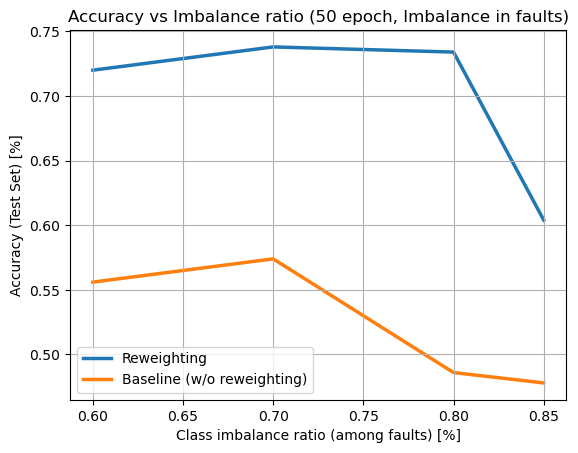

In [19]:
# plot ratio - accruacy graph for both approaches
final_accuracy_base     =   np.empty((0))
final_accuracy_reweight =   np.empty((0))
for idx1 in range(bias_ratio2.shape[0]):
    final_accuracy_base     =   np.append(final_accuracy_base,result_test_acc[idx1][0][-1])
    final_accuracy_reweight =   np.append(final_accuracy_reweight,result_test_acc[idx1][1][-1])

[fig2,ax2]      =   plt.subplots()
reweight2       =   ax2.plot(bias_ratio2,final_accuracy_reweight,linewidth=2.5,label='Reweighting',zorder=0)
baseline2       =   ax2.plot(bias_ratio2,final_accuracy_base,linewidth=2.5,label='Baseline (w/o reweighting)',zorder=1)
ax2.grid()
ax2.set_xlabel('Class imbalance ratio (among faults) [%]')
ax2.set_ylabel('Accuracy (Test Set) [%]')
plt.rcParams["legend.loc"] = 'lower left' 
ax2.legend()
plt.title("Accuracy vs Imbalance ratio (50 epoch, Imbalance in faults)")
plt.savefig('imbal_accuracy6.png')

In [ ]:
# plot ratio - accruacy graph for both approaches
final_accuracy_base     =   np.empty((0))
final_accuracy_reweight =   np.empty((0))
for idx1 in range(bias_ratio1.shape[0]):
    final_accuracy_base     =   np.append(final_accuracy_base,result_test_acc[idx1][0][-1])
    final_accuracy_reweight =   np.append(final_accuracy_reweight,result_test_acc[idx1][1][-1])

[fig2,ax2]      =   plt.subplots()
reweight2       =   ax2.plot(bias_ratio1,final_accuracy_reweight,linewidth=2.5,label='Reweighting',zorder=0)
baseline2       =   ax2.plot(bias_ratio1,final_accuracy_base,linewidth=2.5,label='Baseline (w/o reweighting)',zorder=1)
ax2.grid()
ax2.set_xlabel('Class imbalance ratio (nominal/faults) [%]')
ax2.set_ylabel('Accuracy (Test Set) [%]')
plt.rcParams["legend.loc"] = 'lower right' 
ax2.legend()
plt.title("Accuracy vs Imbalance ratio (50 epoch, Imbalance in nominal/faults)")
plt.savefig('imbal_accuracy2.png')

In [ ]:
# data_path=r'data'

# # load the trajectory and label data saved
# traj_data_dt    =   dt.fread(os.path.join(data_path,"traj_data.csv"), encoding='utf-8')
# traj_data       =   traj_data_dt.to_numpy()
# traj_data       =   traj_data.reshape((-1,13+3+15+4,101,1))


# # read the saved data in csv format
# # using datatable package
# y_pre_dt = dt.fread(os.path.join(train_img_data_path,'y_train.csv'), encoding = 'utf-8')
# y_pre = y_pre_dt['C2'].to_numpy()

# x_pre_raw_list = natsort.natsorted(glob.glob(os.path.join(train_img_data_path,"x_train_*.csv")))
# x_pre = np.empty((len(y_pre),input_dim[1]*input_dim[2]*input_dim[3]+1), dtype = np.uint8)

# temp_ridx = 0
# for file in x_pre_raw_list:
#     x_pre_temp_dt = dt.fread(file, encoding = 'utf-8')
#     x_pre_temp = x_pre_temp_dt.to_numpy()
#     x_pre[temp_ridx:temp_ridx+len(x_pre_temp),:] = x_pre_temp
#     temp_ridx = temp_ridx+len(x_pre_temp)
        
# # check the data integrity (shuffled index check)
# if x_pre.shape[0] != y_pre.shape[0]:
#     raise ValueError

# train_img_process_list = natsort.natsorted(glob.glob(os.path.join(train_img_process_path,"*.jpg")))
# train_img_files_list = []
    
# for file in train_img_process_list:
#     file_name_split = os.path.split(file)
#     file_name_temp = list(file_name_split[1])
#     del file_name_temp[-4:]
#     train_img_files_list.append(int("".join(file_name_temp)))
    
# integrity_check_list = y_pre_dt['C1'].to_list()
# integrity_check_list = integrity_check_list[0]

# for idx in range(len(integrity_check_list)):
#     file_name_temp = list(integrity_check_list[idx])
#     del file_name_temp[-4:]
#     integrity_check_list[idx] = int("".join(file_name_temp))
    
# if (integrity_check_list != train_img_files_list):
#     raise ValueError  

# # remove the photo indices, change the file format and shuffle
# x_pre = x_pre[:,1:]
# y_pre = y_pre

# [x_train, x_valid, y_train, y_valid] = train_test_split(x_pre, y_pre, test_size = 0.10, shuffle = True)

# # reshape for the training process
# x_train = x_train.reshape((-1,input_dim[1],input_dim[2],input_dim[3])).astype(np.float32)
# x_valid = x_valid.reshape((-1,input_dim[1],input_dim[2],input_dim[3])).astype(np.float32)

# # testing one-hot-encoding (wrong accuracy computation in sparse categorical crossentropy)
# onehot = OneHotEncoder(sparse = False)
# onehot.fit(y_train)
# y_train = onehot.transform(y_train)
# y_valid = onehot.transform(y_valid)




# # state_test  =   quad_test.initial_state
# # x_test      =   
# # euler_test  =   np.zeros((3,tsim.shape[0]), dtype=np.float64)
# # 
# # euler_test[:,0]     =   obsv_test.quaternion_to_euler(x_test[6:10,0])
# # xhat_test   =   np.zeros((obsv_test.xhat0.shape[0],tsim.shape[0]), dtype=np.float64)
# # u_test      =   np.zeros((4,tsim.shape[0]), dtype=np.float64)




# # plot
# # 3-d trajectories
# plt.figure(1)
# ax = plt.figure().add_subplot(projection='3d')
# ax.plot(x_test[0,:], x_test[1,:], x_test[2,:], zdir='z', label='curve in (x, y)')

# plt.show()


# plt.figure(2)
# ax1     =   plt.subplot(411)
# ax1.plot(tsim, np.ravel(x_test[3,:]))
# ax1.plot(tsim, np.ravel(x_test[4,:]))
# ax1.plot(tsim, np.ravel(x_test[5,:]))

# ax2     =   plt.subplot(412)
# ax2.plot(tsim, np.ravel(euler_test[0,:])*const['rad2deg'])
# ax2.plot(tsim, np.ravel(euler_test[1,:])*const['rad2deg'])
# ax2.plot(tsim, np.ravel(euler_test[2,:])*const['rad2deg'])

# plt.tight_layout()

# plt.figure(3)
# ax1     =   plt.subplot(411)
# ax1.plot(tsim, np.ravel(euler_test[0,:])*const['rad2deg'])
# ax1.plot(tsim, np.ravel(xhat_test[0,:])*const['rad2deg'])


# plt.show()



# # example_plot(ax)
# # fig.tight_layout()

# # t1 = np.arange(0.0, 3.0, 0.01)

# # ax1 = plt.subplot(212)
# # 

# # ax2 = plt.subplot(221)
# # ax2.margins(2, 2)           # Values >0.0 zoom out
# # ax2.plot(t1, f(t1))
# # ax2.set_title('Zoomed out')

# # ax3 = plt.subplot(222)
# # ax3.margins(x=0, y=-0.25)   # Values in (-0.5, 0.0) zooms in to center
# # ax3.plot(t1, f(t1))
# # ax3.set_title('Zoomed in')

# # plt.show()

# #     print('true')
# #     print(obsv.quaternion_to_euler(state['q'])[1]/np.pi*180)
    
# #     print('estimate')
# #     print(xhat[2]/np.pi*180)
    
# #     print('uf')
# #     print(xhat[6:9])
# #     print(np.linalg.pinv(obsv.CEM[1:4,:])@xhat[6:9][:,np.newaxis])
# #     # print(quad.compute_body_wrench(state, np.array([0.0,0.0,0.0,u[3]]))[1]-quad.compute_body_wrench(state, np.array([0.0,0.0,0.0,0.9*u[3]]))[1])

# #     # print(state['w']/np.pi*180)


In [ ]:








# fix the random seed for the fair comparison with baseline
# generator   =   np.random.seed(seed)

# train_traj_data     =   {}
# train


# traj_data[0,13,:,0]

# # traj_data_class0    =   traj_data[t]
# plt.figure(2)
# ax1     =   plt.subplot(411)
# ax1.plot(np.linspace(0,1,101), np.ravel(traj_data[1,13,:,0]/np.pi*180))
# # ax1.plot(tsim, np.ravel(x_test[4,:]))
# # ax1.plot(tsim, np.ravel(x_test[5,:]))

# ax2     =   plt.subplot(412)
# ax2.plot(np.linspace(0,1,101), np.ravel(traj_data[1,16,:,0]/np.pi*180))
# # ax2.plot(tsim, np.ravel(euler_test[0,:])*const['rad2deg'])
# # ax2.plot(tsim, np.ravel(euler_test[1,:])*const['rad2deg'])
# # ax2.plot(tsim, np.ravel(euler_test[2,:])*const['rad2deg'])

# ax3     =   plt.subplot(413)
# ax3.plot(np.linspace(0,1,101), np.ravel(traj_data[1,13,:,0]/np.pi*180)-np.ravel(traj_data[1,16,:,0]/np.pi*180))